<a href="https://colab.research.google.com/github/vaithak/Quadruped-MPC/blob/main/Simplified_Proj_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install GPy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from GPy.models import GPRegression
from GPy.util.multioutput import LCM
import GPy
import logging
from tqdm import tqdm  # Progress bar for optimization

# ---------------------------------
# Step 1: Generate LF and HF Data
# ---------------------------------
def generate_lf_data(N=100):
    """Generate Low-Fidelity (LF) data: 5 features."""
    # States: x, y, psi, v, psi_dot
    x = np.linspace(0, 10, N)
    y = np.sin(x) * 2
    psi = np.cos(x) * 0.1
    v = np.ones(N) * 5.0  # constant velocity
    psi_dot = np.ones(N) * 0.05

    # State derivatives as outputs
    x_dot = v * np.cos(psi)
    y_dot = v * np.sin(psi)
    psi_dot = psi_dot
    v_dot = np.zeros(N)  # No acceleration
    psi_dot_dot = np.zeros(N)

    states = np.vstack((x, y, psi, v, psi_dot)).T
    outputs = np.vstack((x_dot, y_dot, psi_dot, v_dot, psi_dot_dot)).T
    return states, outputs

def generate_hf_data(N=100):
    """Generate High-Fidelity (HF) data: 7 features (LF + friction + slope)."""
    # LF Features
    states, _ = generate_lf_data(N)
    x, y, psi, v, psi_dot = states.T

    # Friction and slope effects
    friction = np.random.uniform(0.2, 0.3, N)
    slope = np.random.uniform(0, np.pi/6, N)

    # HF state derivatives
    g = 9.81
    x_dot = v * np.cos(psi)
    y_dot = v * np.sin(psi)
    psi_dot = psi_dot
    v_dot = -friction * g * np.sin(slope)
    psi_dot_dot = np.ones(N) * (np.tan(0.05) / 20)  # constant steering

    hf_states = np.vstack((x, y, psi, v, psi_dot, friction, slope)).T
    hf_outputs = np.vstack((x_dot, y_dot, psi_dot, v_dot, psi_dot_dot)).T
    return hf_states, hf_outputs

# Generate LF and HF data
N_LF = 1000
N_HF = 200
LF_states, LF_outputs = generate_lf_data(N_LF)  # LF data: 5 features, 5 outputs
HF_states, HF_outputs = generate_hf_data(N_HF)  # HF data: 7 features, 5 outputs

# -------------------------------------------------
# Step 2: Multi-Fidelity Gaussian Process (MFGP)
# -------------------------------------------------
# Pad LF inputs with zeros to match HF input dimensions
LF_states_padded = np.hstack((LF_states, np.zeros((N_LF, 2))))  # Add 2 zero columns for friction & slope

# Combine LF and HF data
X_LF = LF_states_padded
X_HF = HF_states
Y_LF = LF_outputs
Y_HF = HF_outputs

# Stack LF and HF inputs and outputs
X = np.vstack((X_LF, X_HF))  # Combined input features
Y = np.vstack((Y_LF, Y_HF))  # Combined outputs (all state derivatives)

In [ ]:
print(X_LF.shape)
print(X_HF.shape)
print(Y_LF.shape)
print(Y_HF.shape)

(1000, 7)
(200, 7)
(1000, 5)
(200, 5)


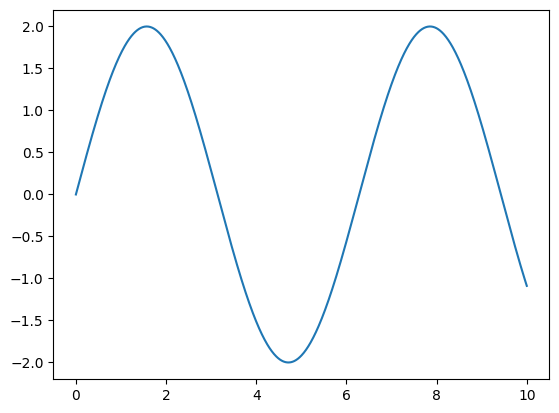

In [ ]:
plt.plot(X_LF[:,0],X_LF[:,1])


In [ ]:
# Create "fidelity labels" (0 for LF, 1 for HF)
fidelity_LF = np.zeros((N_LF, 1))
fidelity_HF = np.ones((N_HF, 1))

# Combine fidelity labels with inputs
X_combined = np.hstack((X, np.vstack((fidelity_LF, fidelity_HF))))  # Add fidelity indicator as an input

Optimizing: 100%|██████████| 100/100 [29:54<00:00, 17.95s/iter]


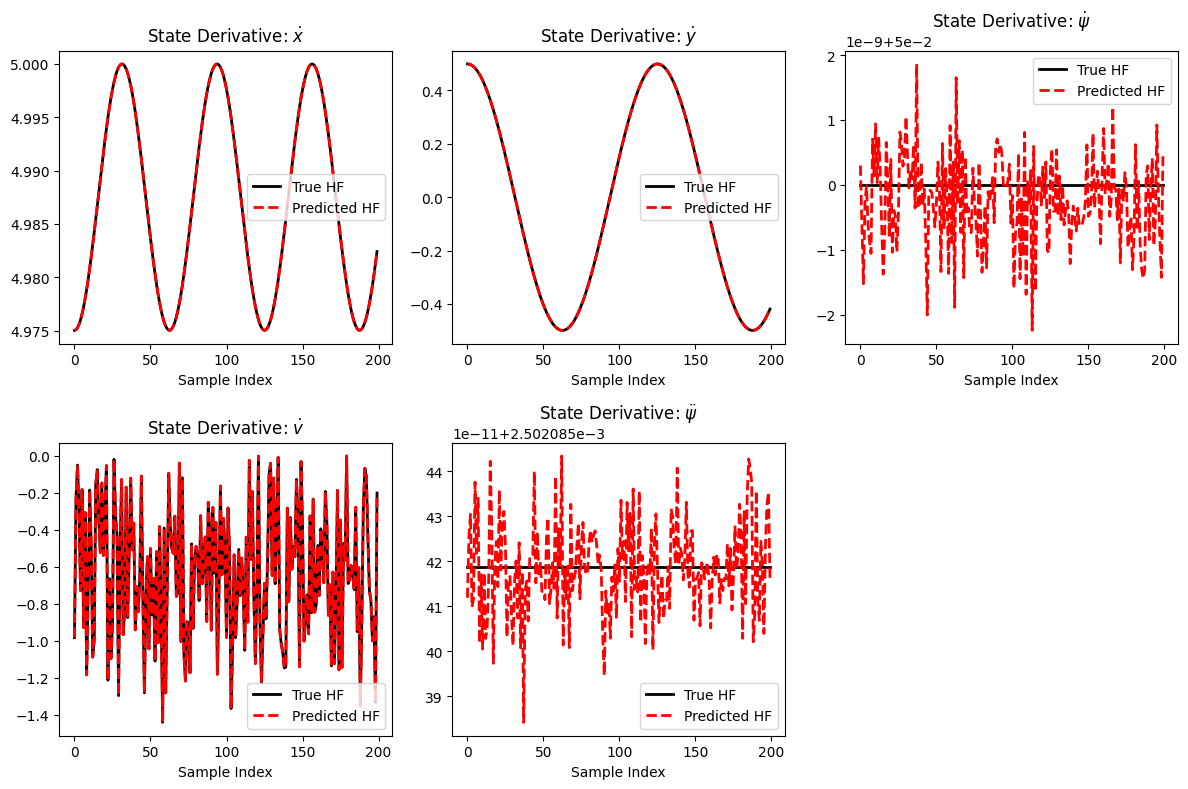

In [ ]:
# Step 3: Train Multi-Output GP Model using LCM
# -------------------------------------------------
# Define a list of kernels (one for each output)
kernels_list = [GPy.kern.RBF(input_dim=7) for _ in range(5)]  # Use RBF kernel for each output

# Create the LCM kernel with the list of kernels
kernel = LCM(input_dim=7, num_outputs=5, kernels_list=kernels_list, W_rank=5)  # 8 inputs (7 features + fidelity), 5 outputs

# Train the GP model
model = GPy.models.GPRegression(X_combined, Y, kernel)


# Setup logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Function to optimize the model and log losses with progress bar
def optimize_model(model, num_iterations=100):
    """Optimize the GP model and log losses with progress bar."""
    for _ in tqdm(range(num_iterations), desc="Optimizing", unit="iter"):
        model.optimize(messages=False)  # Optimization step without printing messages
        loss = model.log_likelihood()  # Log the loss after optimization
        logger.info(f"Current Loss: {loss:.4f}")


optimize_model(model)

# -------------------------------------------------
# Step 4: Predict HF Outputs
# -------------------------------------------------
# Test data: HF states with fidelity label = 1
X_test = np.hstack((HF_states, np.ones((N_HF, 1))))  # Add fidelity label for HF
Y_pred, Y_var = model.predict(X_test, full_cov=False)

# -------------------------------------------------
# Step 5: Plot Results for Each Output
# -------------------------------------------------
output_labels = [r'$\dot{x}$', r'$\dot{y}$', r'$\dot{\psi}$', r'$\dot{v}$', r'$\ddot{\psi}$']

plt.figure(figsize=(12, 8))
for i in range(5):  # Loop over the 5 outputs
    plt.subplot(2, 3, i+1)
    plt.plot(Y_HF[:, i], 'k', lw=2, label="True HF")
    plt.plot(Y_pred[:, i], 'r--', lw=2, label="Predicted HF")
    #plt.fill_between(range(N_HF),
    #                 (Y_pred[:, i] - 2 * np.sqrt(Y_var[:, i])).flatten(),
    #                 (Y_pred[:, i] + 2 * np.sqrt(Y_var[:, i])).flatten(),
    #                 color='red', alpha=0.2, label="Confidence Interval")
    plt.title(f"State Derivative: {output_labels[i]}")
    plt.xlabel("Sample Index")
    plt.legend()

plt.tight_layout()
plt.show()

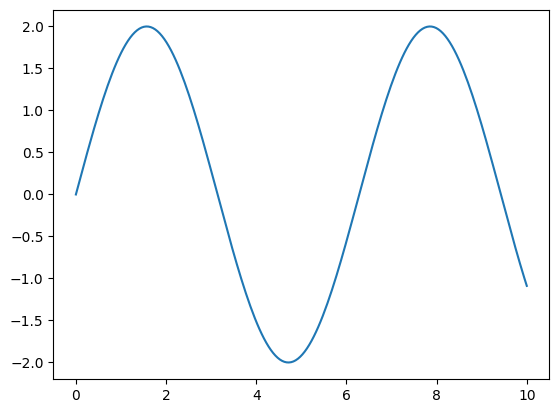

In [ ]:
plt.plot(X_test[:,0],X_test[:,1]) #STATES

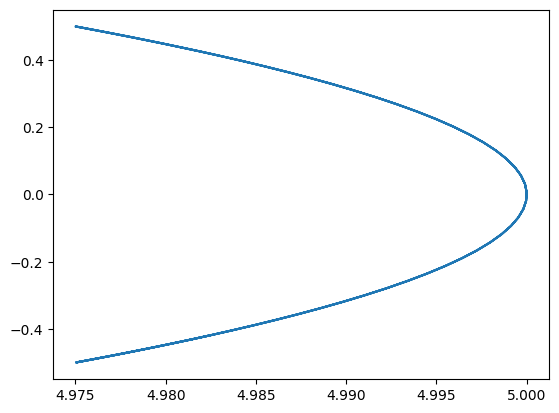

In [ ]:
plt.plot(Y_pred[:,0],Y_pred[:,1]) #STATE DERIVATIVES

In [ ]:
# System parameters (assumed values)
L = 2.5  # vehicle wheelbase (meters)
mu = 0.25  # friction coefficient (for example)
theta = torch.tensor(0.0, dtype=torch.float32)

# Define the Physics Loss Function
def compute_physics_loss(X, Y_pred):
    """
    Computes the physics loss based on the vehicle dynamics equations.

    Parameters:
    - X: Input states, shape (N, input_dim) [x, y, psi, v]
    - Y_pred: Predicted state derivatives, shape (N, output_dim) [x_dot, y_dot, psi_dot, v_dot, psi_dot_dot]

    Returns:
    - physics_loss: The total physics loss.
    """
    # Extract the predicted derivatives
    x_dot_pred = Y_pred[:, 0]
    y_dot_pred = Y_pred[:, 1]
    psi_dot_pred = Y_pred[:, 2]
    v_dot_pred = Y_pred[:, 3]
    psi_dot_dot_pred = Y_pred[:, 4]

    # Extract the input states
    x = X[:, 0]
    y = X[:, 1]
    psi = X[:, 2]
    v = X[:, 3]

    # Compute the state derivatives using the physics model
    x_dot_phys = v * torch.cos(psi)
    y_dot_phys = v * torch.sin(psi)
    psi_dot_phys = v / L * torch.tan(psi)
    v_dot_phys = mu * torch.cos(theta) * v**2 / L  # Assuming simple friction model

    # Compute the residuals (the difference between predicted and physics-based derivatives)
    residual_x_dot = x_dot_pred - x_dot_phys
    residual_y_dot = y_dot_pred - y_dot_phys
    residual_psi_dot = psi_dot_pred - psi_dot_phys
    residual_v_dot = v_dot_pred - v_dot_phys

    # Compute the total physics loss as the sum of squared residuals
    physics_loss = torch.mean(residual_x_dot**2 + residual_y_dot**2 + residual_psi_dot**2 + residual_v_dot**2)

    return physics_loss

 <ipython-input-63-71e5d248ecc3>:35: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 10000/10000 [01:42<00:00, 97.83it/s]


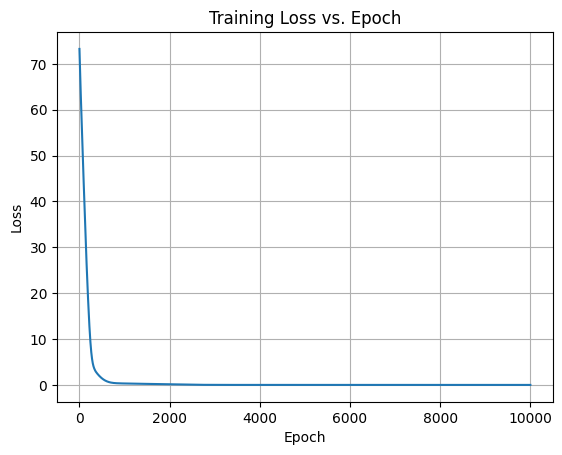

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

# Example PINN model (simplified)
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 1024)
        self.layer3 = nn.Linear(1024, 256)
        self.output_layer = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.output_layer(x)

# Define a loss function combining physics and data
def loss_fn(y_pred, y_true, physics_loss):
    data_loss = torch.mean((y_pred - y_true)**2)
    total_loss = data_loss + lambda_ * physics_loss
    return total_loss

# Set up the PINN and optimizer
pinn_model = PINN(input_dim=7, output_dim=5)  # Assuming  inputs and 5 outputs (state derivatives)
optimizer = optim.Adam(pinn_model.parameters(), lr=0.00001)
lambda_ = 2
train_losses = []


X_tensor = torch.tensor(HF_states, dtype=torch.float32)  # Convert X to a tensor
Y_tensor = torch.tensor(Y_pred, dtype=torch.float32)  # Convert Y to a tensor

# Example training loop
for epoch in trange(10000):
    pinn_model.train()
    optimizer.zero_grad()

    # Forward pass (assuming X_train contains state inputs and Y_train contains GP-predicted derivatives)
    Y_pred = pinn_model(X_tensor)

    # Physics loss (using system dynamics)
    physics_loss = compute_physics_loss(X_tensor,Y_pred)  # Implement this based on the system equations

    # Data loss (GP predictions vs PINN predictions)
    data_loss = torch.mean((Y_pred - Y_tensor)**2)

    # Total loss
    loss = loss_fn(Y_pred, Y_tensor, physics_loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

# Plotting the loss graph after training
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.show()





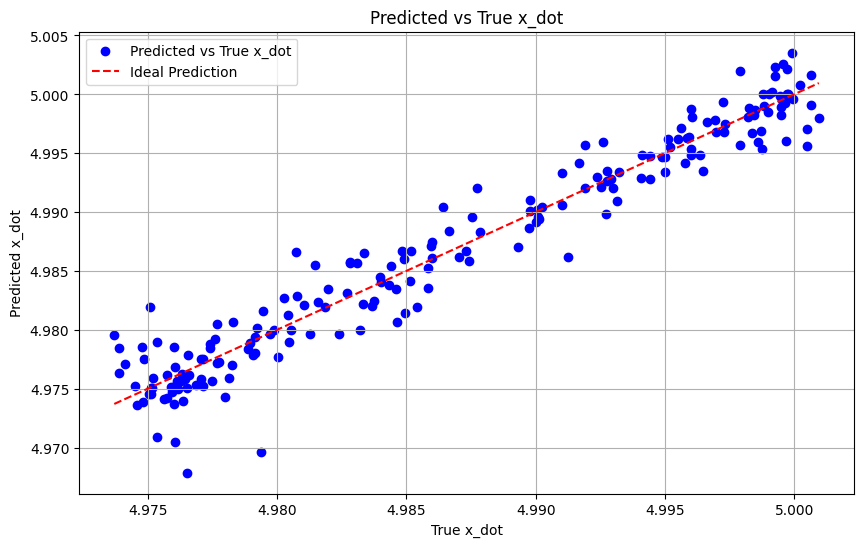

In [ ]:
# After training is done and we have predictions (Y_pred) and true values (Y_train)
# We will plot the predicted vs. true values for each of the state derivatives.

# Example: Predicted vs True for x_dot
plt.figure(figsize=(10, 6))
plt.scatter(Y_tensor[:, 0].detach().numpy(), Y_pred[:, 0].detach().numpy(), color='blue', label='Predicted vs True x_dot')
plt.plot([min(Y_tensor[:, 0].detach().numpy()), max(Y_tensor[:, 0].detach().numpy())],
         [min(Y_tensor[:, 0].detach().numpy()), max(Y_tensor[:, 0].detach().numpy())], 'r--', label='Ideal Prediction')
plt.xlabel('True x_dot')
plt.ylabel('Predicted x_dot')
plt.legend()
plt.title('Predicted vs True x_dot')
plt.grid(True)
plt.show()

# Repeat for other state derivatives like y_dot, psi_dot, v_dot, psi_dot_dot


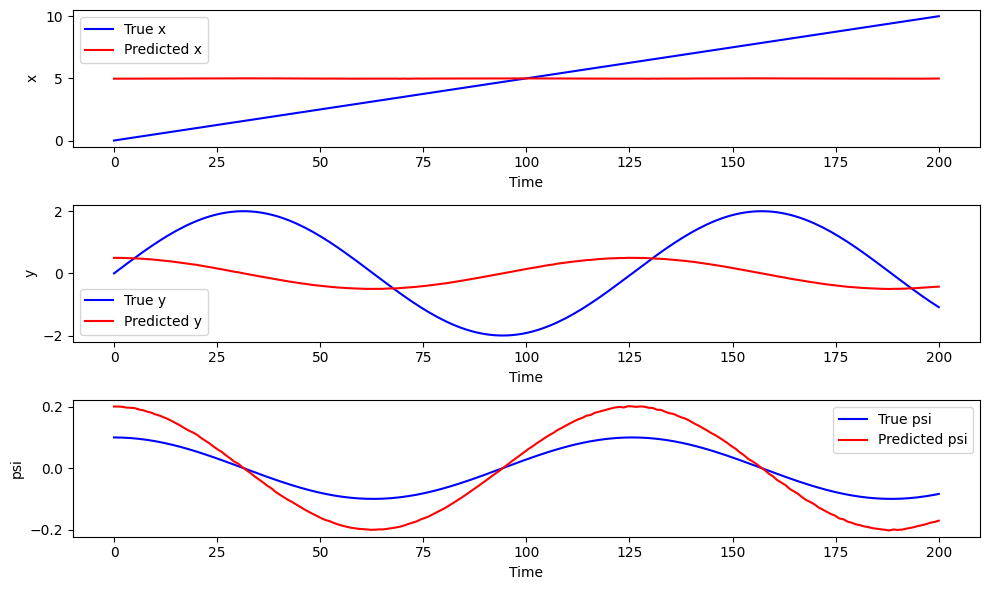

In [ ]:
# Assuming you have time or iteration indices to plot over
time = np.linspace(0, len(X_tensor), len(X_tensor))

# Plot state trajectory for x, y, psi
plt.figure(figsize=(10, 6))

# Plot for x
plt.subplot(3, 1, 1)
plt.plot(time, X_tensor[:, 0].detach().numpy(), label='True x', color='blue')
plt.plot(time, Y_pred[:, 0].detach().numpy(), label='Predicted x', color='red')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()

# Plot for y
plt.subplot(3, 1, 2)
plt.plot(time, X_tensor[:, 1].detach().numpy(), label='True y', color='blue')
plt.plot(time, Y_pred[:, 1].detach().numpy(), label='Predicted y', color='red')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()

# Plot for psi
plt.subplot(3, 1, 3)
plt.plot(time, X_tensor[:, 2].detach().numpy(), label='True psi', color='blue')
plt.plot(time, Y_pred[:, 2].detach().numpy(), label='Predicted psi', color='red')
plt.xlabel('Time')
plt.ylabel('psi')
plt.legend()

plt.tight_layout()
plt.show()


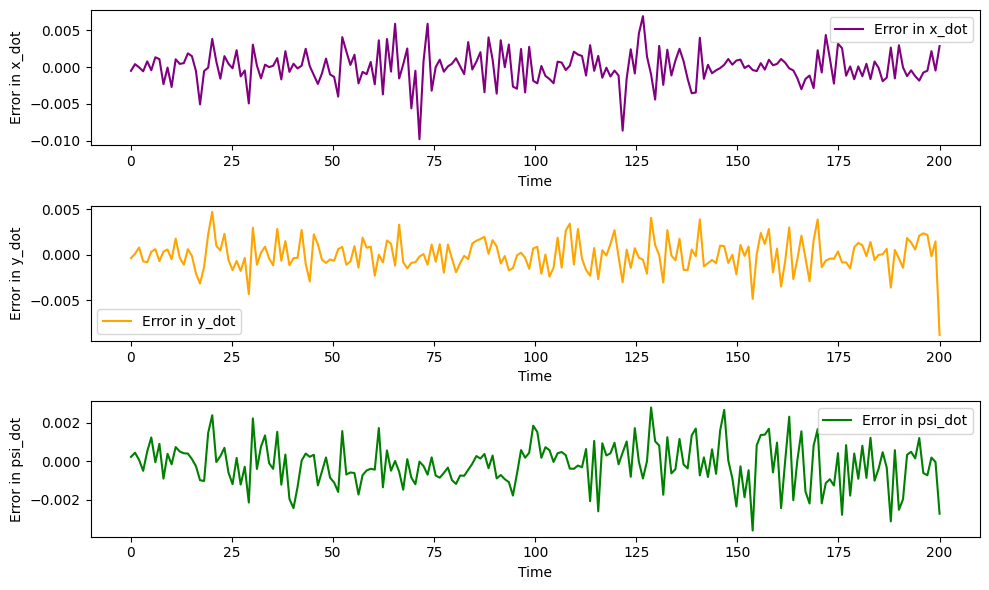

In [ ]:
# Calculate the prediction error
prediction_error = Y_pred.detach().numpy() - Y_tensor.detach().numpy()

# Plot the error for each state variable
plt.figure(figsize=(10, 6))

# Plot error for x_dot
plt.subplot(3, 1, 1)
plt.plot(time, prediction_error[:, 0], label='Error in x_dot', color='purple')
plt.xlabel('Time')
plt.ylabel('Error in x_dot')
plt.legend()

# Plot error for y_dot
plt.subplot(3, 1, 2)
plt.plot(time, prediction_error[:, 1], label='Error in y_dot', color='orange')
plt.xlabel('Time')
plt.ylabel('Error in y_dot')
plt.legend()

# Plot error for psi_dot
plt.subplot(3, 1, 3)
plt.plot(time, prediction_error[:, 2], label='Error in psi_dot', color='green')
plt.xlabel('Time')
plt.ylabel('Error in psi_dot')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Define the circular trajectory parameters
radius = 10  # radius of the circular path in meters
center_x, center_y = 0, 0  # center of the circular path
v = 5  # constant speed in m/s

# Define the Pure Pursuit controller
def pure_pursuit_controller(state, lookahead_distance):
    """
    Compute the steering angle (delta) using Pure Pursuit.
    :param state: Current state of the vehicle (x, y, psi).
    :param lookahead_distance: Lookahead distance for the controller.
    :return: Steering angle (delta).
    """
    x, y, psi,_,_ = state  # Current state: position and orientation

    # Desired position on the circular path (target ahead of current position)
    target_x = center_x + radius * np.cos(np.arctan2(y - center_y, x - center_x) + lookahead_distance / radius)
    target_y = center_y + radius * np.sin(np.arctan2(y - center_y, x - center_x) + lookahead_distance / radius)

    # Compute the steering angle based on the geometry of Pure Pursuit
    dx = target_x - x
    dy = target_y - y
    alpha = np.arctan2(dy, dx) - psi  # Heading error
    delta = np.arctan2(2 * radius * np.sin(alpha), lookahead_distance)  # Steering angle formula

    return delta


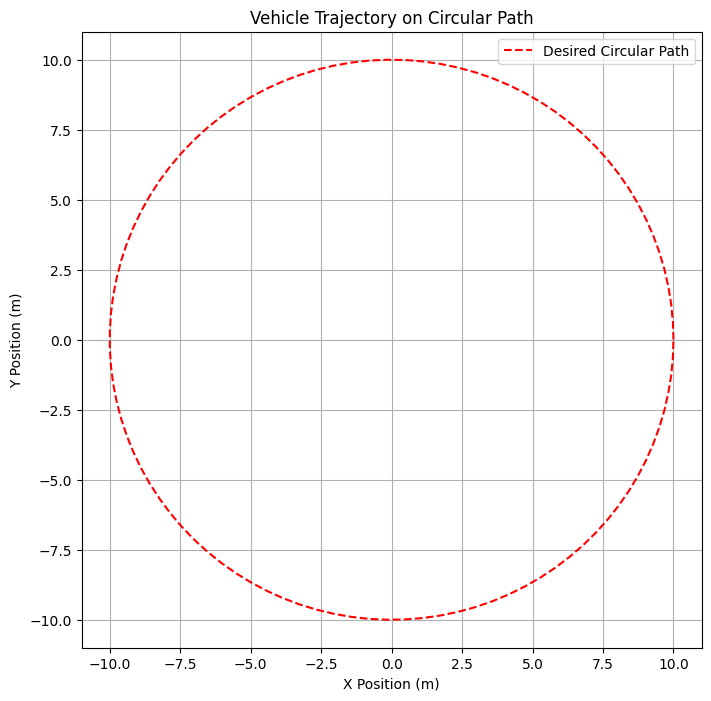

In [ ]:
import matplotlib.pyplot as plt

# Initialize the state (x, y, psi, v, psi_dot)
initial_state = np.array([0, 0, 0, 5, 0])  # Initial position, velocity, and heading

# Define simulation parameters
time_steps = 1000
dt = 0.1  # Time step in seconds
lookahead_distance = 2  # Lookahead distance for the Pure Pursuit controller

# Storage for trajectory
x_trajectory = []
y_trajectory = []

# Simulate the trajectory
test_state = initial_state
for t in range(time_steps):
    # Get control inputs (delta, a) from the controller
    delta = pure_pursuit_controller(test_state, lookahead_distance)
    a = 0  # Constant speed, so acceleration is zero
    x = test_state[0]
    y = test_state[1]
    psi = test_state [2] + delta
    v = test_state[3]
    psi_dot = test_state[4]
    test_state = np.array([x, y, psi, v, psi_dot])
    test_state2 = np.array([x, y, psi, v, psi_dot,0 , 0])

    # Predict the state derivatives using the model (e.g., from MFGP model or physics model)
    Y_pred = pinn_model(torch.Tensor(test_state2))  # Assuming 'model' is the trained model

    # Update the state using the predicted derivatives
    state_dot = Y_pred.detach().numpy()
    test_state = test_state + state_dot.flatten() * dt  # Euler integration step

    # Store the state for visualization
    x_trajectory.append(test_state[0])
    y_trajectory.append(test_state[1])

# Plot the trajectory
plt.figure(figsize=(8, 8))
#plt.plot(x_trajectory, y_trajectory, label="Predicted Trajectory")
plt.plot(center_x + radius * np.cos(np.linspace(0, 2*np.pi, 100)),
         center_y + radius * np.sin(np.linspace(0, 2*np.pi, 100)),
         'r--', label="Desired Circular Path")
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Vehicle Trajectory on Circular Path')
plt.legend()
plt.grid(True)
plt.show()


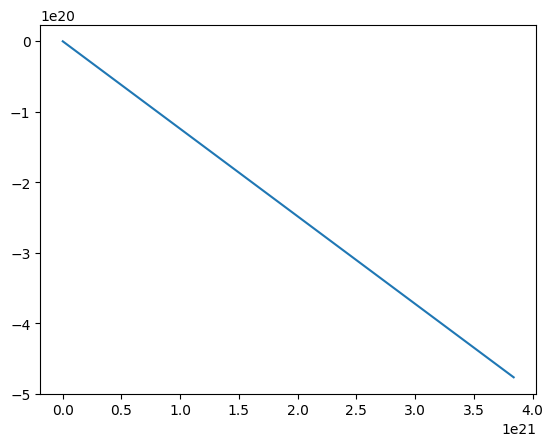

In [ ]:
plt.plot(x_trajectory, y_trajectory, label="Predicted Trajectory")